In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [70]:
%matplotlib inline

from typing import List

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.neighbors import NearestNeighbors
from catboost import CatBoostClassifier

from nf.flows import *
from nf.models import NormalizingFlowModel
import matplotlib.pyplot as plt

In [3]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


In [4]:
device = 'cuda'
batch_size = 2 * 10**5
data_dir = '../data/data_calibsample'
particle = 'muon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

In [5]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
168632,0.952944,6801.29,2.72279,205,7.44195,-12.01900,-7.19419,7.44195,7.44195
177965,-0.370586,19226.10,3.56168,247,-32.46170,2.07285,3.36751,-49.08420,-33.45150
384128,0.203051,4233.18,2.58061,150,-28.12360,-42.86560,-46.49680,-28.12360,-28.12360
372397,-0.377776,19251.20,4.39975,93,-9.58219,4.53198,1.02102,-9.27543,-12.02590
295609,-0.384684,7305.37,2.09972,168,-17.32700,2.68227,14.93740,-17.32700,-17.32700


In [6]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(1984209, 9)

In [7]:
X, Y, weights = data[features].values.astype(np.float32), data[dlls].values.astype(np.float32), data[weight_filed].values.astype(np.float32)
train_size = data.shape[0] * 7 // 10

X_train_, Y_train_, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val_, Y_val_, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train_.shape, X_val_.shape

((1388946, 3), (595263, 3))

In [8]:
class DataPreprocessor:
    def __init__(self):
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

    def fit(self, X, Y):
        self.y_scaler.fit(Y)
        self.x_scaler.fit(np.log(X + 1))
        return self
    
    def transform(self, X, Y):
        return self.x_scaler.transform(np.log(X + 1)), self.y_scaler.transform(Y)
    
    def inverse_transform(self, X, Y):
        return np.exp(self.x_scaler.inverse_transform(X)) - 1, self.y_scaler.inverse_transform(Y)

In [9]:
preprocessor = DataPreprocessor().fit(X_train_, Y_train_)
X_train, Y_train = preprocessor.transform(X_train_, Y_train_)
X_val, Y_val = preprocessor.transform(X_val_, Y_val_)

In [10]:
X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test_tensor = torch.from_numpy(X_val.astype(np.float32)).to(device)
Y_train_tensor = torch.from_numpy(Y_train.astype(np.float32)).to(device)
Y_test_tensor = torch.from_numpy(Y_val.astype(np.float32)).to(device)

In [11]:
def get_data_generator(X, Y, batch_size):
    assert(len(X) == len(Y))
    while True:
        for i in range(0, len(X), batch_size):
            yield (Y[i: i + batch_size], X[i: i + batch_size])

data_gen = get_data_generator(X_train_tensor, Y_train_tensor, batch_size)

In [12]:
class ConditionalNormalizingFlowModel(nn.Module):

    def __init__(self, dim, condition_dim, prior, flows, mu=FCNN, log_sigma=FCNN, hidden_dim=8):
        super().__init__()
        self.dim = dim
        self.condition_dim = condition_dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)
        self.mu = mu(condition_dim, dim, hidden_dim)
        self.log_sigma = log_sigma(condition_dim, dim, hidden_dim)

    def forward(self, x, condition):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            if hasattr(flow, 'is_conditional'):
                x, ld = flow.forward(x, condition)
            else:
                x, ld = flow.forward(x)
            log_det += ld
        
        mu, log_sigma = self.mu(condition), self.log_sigma(condition)
        x = (x - mu) * torch.exp(-log_sigma)
        log_det -= log_sigma.sum(dim=1)
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def backward(self, z, condition):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        mu, log_sigma = self.mu(condition), self.log_sigma(condition)
        z = z * torch.exp(log_sigma) + mu
        log_det += log_sigma.sum(dim=1)
        for flow in self.flows[::-1]:
            if hasattr(flow, 'is_conditional'):
                z, ld = flow.backward(z, condition)
            else:
                z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det

In [72]:
class ConditionalMAF(nn.Module):
    def __init__(self, dim, cond_dim, hidden_dim=8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i + cond_dim, 2, hidden_dim)]
        self.reset_parameters()
    
    @staticmethod
    def is_conditional():
        return True
    
    @staticmethod
    def init_linear(i):
        def f(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 1e-2 / i)
                torch.nn.init.normal_(m.bias, 0, 1e-2 / i)
        return f
                
    def reset_parameters(self):
        nn.init.normal_(self.initial_param, 0, 1e-2)

        for i, layer in enumerate(self.layers):
            layer.apply(self.init_linear(i + 1))

    def forward(self, x, condition):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z, condition):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det
    
    def sample_n(self, n, condition, return_tensor=False):
        z = prior.sample_n(n)
        samples, _ = model.backward(z, condition)
        if return_tensor:
            return samples
        else:
            return samples.detach().cpu().numpy()

In [73]:
class ActNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        # TODO: Fix global .to(device) here
        self.mu = nn.Parameter(torch.zeros(dim, dtype = torch.float).to(device))
        self.log_sigma = nn.Parameter(torch.zeros(dim, dtype = torch.float).to(device))
        
        self.init()
    
    def init(self):
        torch.nn.init.normal_(self.mu, 0, 2e-5)
        torch.nn.init.normal_(self.log_sigma, 0, 2e-5)

    def forward(self, x):
        z = x * torch.exp(self.log_sigma) + self.mu
        log_det = torch.sum(self.log_sigma)
        return z, log_det

    def backward(self, z):
        x = (z - self.mu) / torch.exp(self.log_sigma)
        log_det = -torch.sum(self.log_sigma)
        return x, log_det

In [74]:
class InnerNN(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden_dim: int):
        super().__init__()
#         activation = nn.Tanh
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [87]:
class Densnet(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden_dims: List[int]):
        super().__init__()
        self.layers = []
        x = in_dim
        for dim in hidden_dims + [out_dim]:
            self.layers.append(nn.Linear(x, dim))
            x += dim
            
        self.layers = nn.ModuleList(self.layers)
        self.activations = [nn.ReLU()] * (len(hidden_dims) - 1)
        self.activations.append(nn.Tanh())
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layers[0](x)
        for activation, layer in zip(self.layers[1:], self.activations):
            x = torch.cat([x, out], dim=1)
            out = layer(activation(x))
        return out

In [153]:
dim, cond_dim = len(dlls), len(features)

flows = []
for i in range(10):
    flows.append(ActNorm(dim=dim).to(device))
    flows.append(ConditionalMAF(dim, cond_dim, hidden_dim=[8, 8, 8, 8], base_network=Densnet).to(device))

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
# model.apply(init_linear)
optimizer = optim.Adam(model.parameters(), lr=0.003)
metrics_ll_train, metrics_ll_test = [], []
step_freq = 200
best_loss = 2.5

3.389746880531311


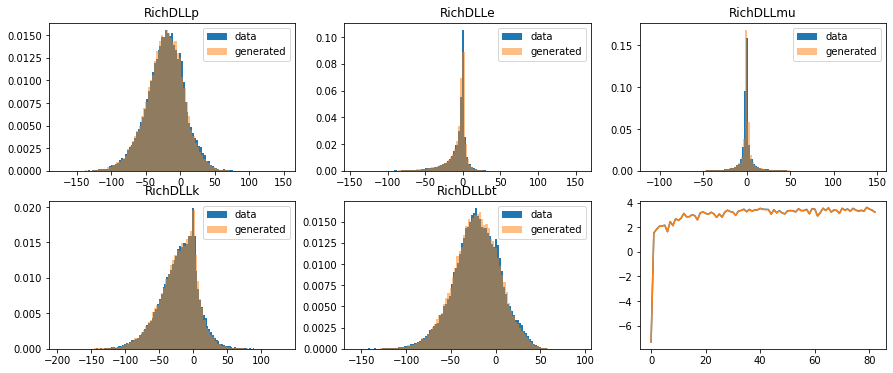

KeyboardInterrupt: 

In [148]:
epoches = 100000
n_samples = 50000
for i in range(step_freq * len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    Y_batch, X_batch = next(data_gen)
    z, logp_z, log_det = model(Y_batch, X_batch)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), 10.0)
    optimizer.step()

    if i % step_freq == 0:
        model.eval()
        with torch.no_grad():
            _, logp_z, log_det = model(Y_train_tensor[:n_samples], X_train_tensor[:n_samples])
            metrics_ll_train.append(torch.mean(logp_z + log_det).item())
            _, logp_z, log_det = model(Y_test_tensor[:n_samples], X_test_tensor[:n_samples])
            metrics_ll_test.append(torch.mean(logp_z + log_det).item())
            
            z = prior.sample_n(n_samples)
            samples, _ = model.backward(z, X_test_tensor[:n_samples])
            samples = samples.detach().cpu().numpy()
            samples = preprocessor.y_scaler.inverse_transform(samples)
        
        if metrics_ll_train[-1] > best_loss:
            best_loss = metrics_ll_train[-1]
            torch.save(model.state_dict(), f'model_densnet_10/model_{i}_{best_loss}')
            torch.save(optimizer.state_dict(), f'model_densnet_10/optim_{i}_{best_loss}')

        clear_output(True)
        print(np.mean(metrics_ll_train[-10:]))
        fig, axs = plt.subplots(2, 3, figsize=(15, 6))
        
        axs[1, 2].plot(metrics_ll_train)
        axs[1, 2].plot(metrics_ll_test)

        for i in range(dim):
            axs[i // 3, i % 3].hist(Y_val_[:n_samples, i], 100, label="data", density=True)
            axs[i // 3, i % 3].hist(samples[:, i], 100, label="generated", density=True, alpha=0.5)
            axs[i // 3, i % 3].legend()
            axs[i // 3, i % 3].set_title(dlls[i])
        
        plt.show()

In [149]:
! ls model_densnet_10

model_12600_3.538811445236206	optim_12600_3.538811445236206
model_13000_3.567744255065918	optim_13000_3.567744255065918
model_15800_3.6113603115081787	optim_15800_3.6113603115081787
model_1800_2.6891305446624756	optim_2200_2.733267068862915
model_2200_2.733267068862915	optim_2400_3.115868091583252
model_2400_3.115868091583252	optim_3600_3.1503021717071533
model_3600_3.1503021717071533	optim_3800_3.2462692260742188
model_3800_3.2462692260742188	optim_5600_3.3787949085235596
model_5600_3.3787949085235596	optim_6800_3.4589126110076904
model_6800_3.4589126110076904	optim_8000_3.527888774871826
model_8000_3.527888774871826


In [154]:
model.load_state_dict(torch.load('model_densnet_10/model_15800_3.6113603115081787'))

<All keys matched successfully>

3.5746099948883057


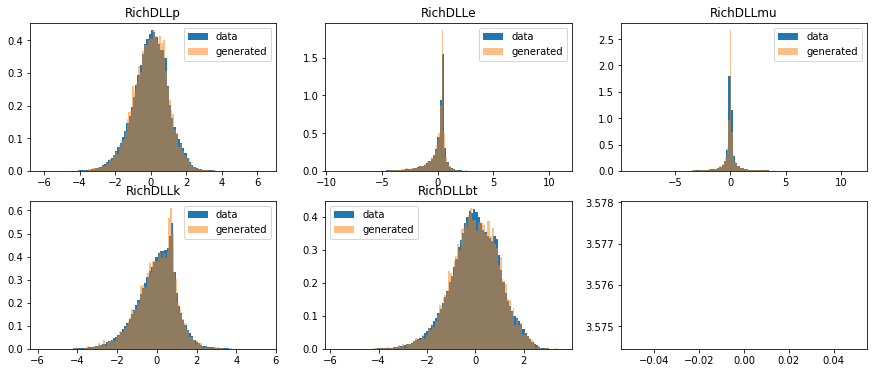

In [155]:
model.eval()
with torch.no_grad():
    _, logp_z, log_det = model(Y_train_tensor[:10000], X_train_tensor[:10000])
    metrics_ll_train.append(torch.mean(logp_z + log_det).item())
    _, logp_z, log_det = model(Y_test_tensor[:10000], X_test_tensor[:10000])
    metrics_ll_test.append(torch.mean(logp_z + log_det).item())

    z = prior.sample_n(10000)
    samples, _ = model.backward(z, X_test_tensor[:10000])
    samples = samples.detach().cpu().numpy()
#     samples = preprocessor.y_scaler.inverse_transform(samples)

clear_output(True)
print(np.mean(metrics_ll_train[-10:]))
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[1, 2].plot(metrics_ll_train)
axs[1, 2].plot(metrics_ll_test)

for i in range(dim):
    axs[i // 3, i % 3].hist(preprocessor.y_scaler.transform(Y_val_)[:, i], 100, label="data", density=True)
    axs[i // 3, i % 3].hist(samples[:, i], 100, label="generated", density=True, alpha=0.5)
    axs[i // 3, i % 3].legend()
    axs[i // 3, i % 3].set_title(dlls[i])

plt.show()

In [157]:
samples = []
model.eval()
with torch.no_grad():
    for i in range(0, len(X_test_tensor), batch_size):
        batch = X_test_tensor[i: i + batch_size]

        z = prior.sample_n(len(batch))
        samples_, _ = model.backward(z, batch)
        samples_ = samples_.detach().cpu().numpy()
        samples_ = preprocessor.y_scaler.inverse_transform(samples_)
        samples.append(samples_)
samples = np.vstack(samples)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [158]:
d1 = pd.DataFrame(np.hstack([Y_val_, X_val_, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_val_, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsGenerated'] = False
d2['IsGenerated'] = True
d2.head()

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsGenerated
0,-61.842796,0.247854,-0.208734,-28.548534,-44.346512,45755.300781,3.38319,155.0,1.083820,True
1,-18.006176,0.720785,0.474350,-3.011173,-0.160889,79157.796875,3.72234,605.0,-0.342797,True
2,-18.470850,-11.792454,13.891500,-18.565449,-18.547285,8822.259766,2.71810,411.0,1.229230,True
3,-73.470383,-9.725226,1.023537,-90.077705,-72.892097,17775.000000,2.79831,194.0,1.250350,True
4,-136.173447,-5.080760,0.125736,-124.547806,-117.202751,27531.099609,3.20261,83.0,0.633744,True


In [159]:
def plot_joint_dll_distributions(data, dlls):
    fig, axs = plt.subplots(len(dlls), len(dlls), figsize=(17, 15))#, sharex=True, sharey=True)

    for j, dll1 in enumerate(dlls):
        for i, dll2 in enumerate(dlls):
            q1_1, q1_99 = data[dll1].quantile(0.03), data[dll1].quantile(0.97)
            q2_1, q2_99 = data[dll2].quantile(0.03), data[dll2].quantile(0.97)

            if i == j:
                arr = data[[dll1]].query(f'{q1_1} < {dll1} < {q1_99}')
                axs[i, i].hist(arr[dll1], 100)
                axs[i, i].set_title(dll1)
            else:
                arr = data[[dll1, dll2]] \
                    .query(f'{q1_1} < {dll1} < {q1_99}') \
                    .query(f'{q2_1} < {dll2} < {q2_99}')

                axs[i, j].hist2d(arr[dll1], arr[dll2], (100, 100, ))
                m1, m2 = max(q1_1, q2_1), min(q1_99, q2_99)
                axs[i, j].plot(np.arange(m1, m2, 1), np.arange(m1, m2, 1), c='red')
                axs[i, j].set_title(dll1 + ' ' + dll2)

## Original data distributions

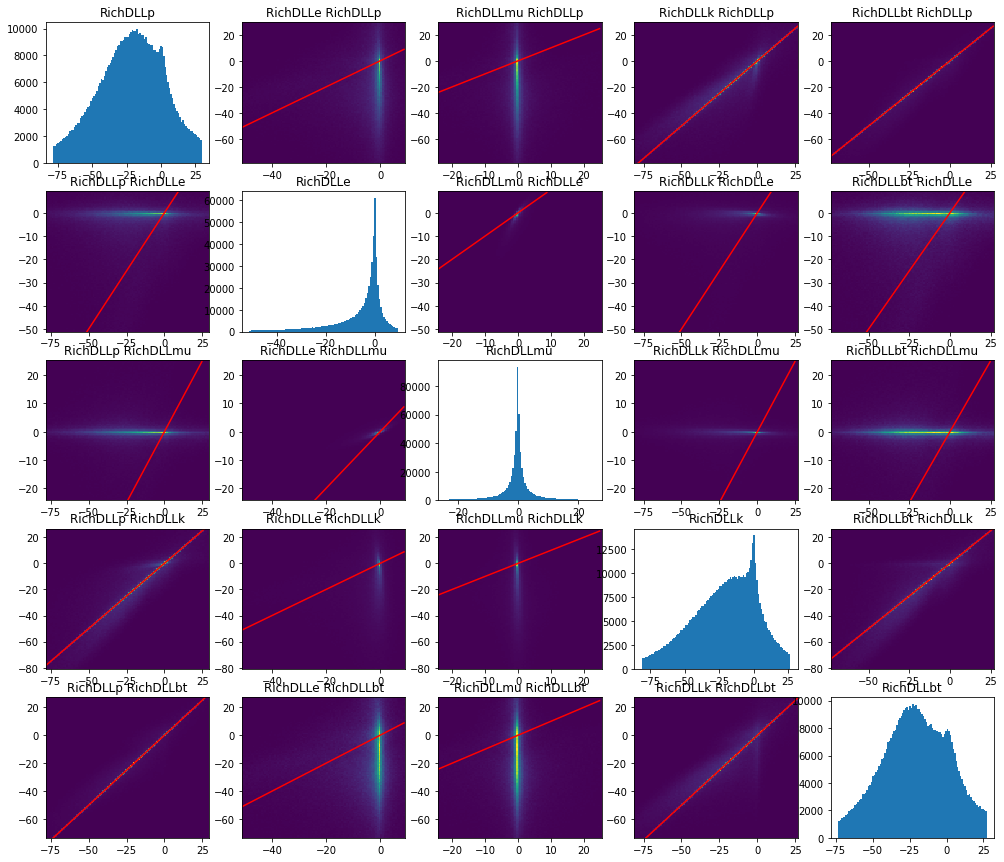

In [160]:
plot_joint_dll_distributions(d1, dlls)

## Generated data distributions

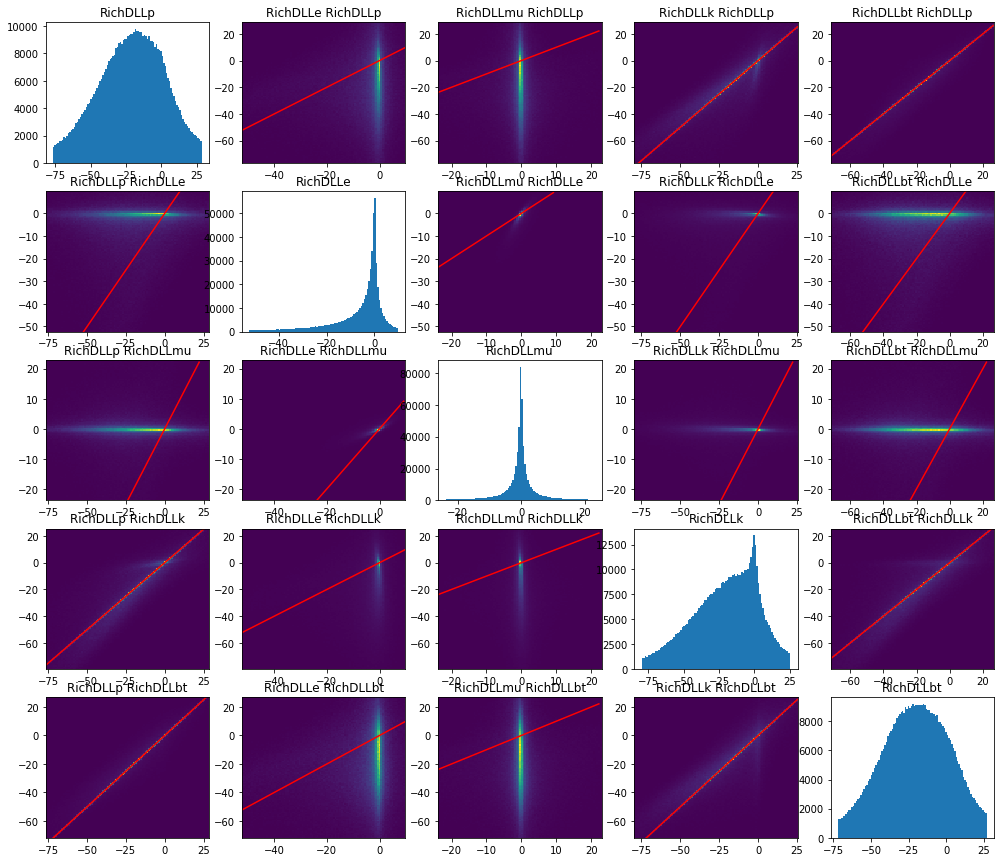

In [161]:
plot_joint_dll_distributions(d2, dlls)

In [162]:
def plot_joint_cond_dll_distributions(data, dll, features):
    fig, axs = plt.subplots(len(dlls) + 1, len(features), figsize=(17, 17))

    for j, f in enumerate(features):
        for i, dll in enumerate([None] + dlls):
            q2_1, q2_99 = data[f].quantile(0.03), data[f].quantile(0.97)
            if i == 0:
                arr = data[[f]].query(f'{q2_1} < {f} < {q2_99}')
                axs[i, j].hist(arr[f], 500)
                axs[i, j].set_title(f)
            else:
                q1_1, q1_99 = data[dll].quantile(0.03), data[dll].quantile(0.97)        

                arr = data[[dll, f]] \
                    .query(f'{q1_1} < {dll} < {q1_99}') \
                    .query(f'{q2_1} < {f} < {q2_99}')

                axs[i, j].hist2d(arr[f], arr[dll], (100, 100, ))
                axs[i, j].set_title(f + ' ' + dll)

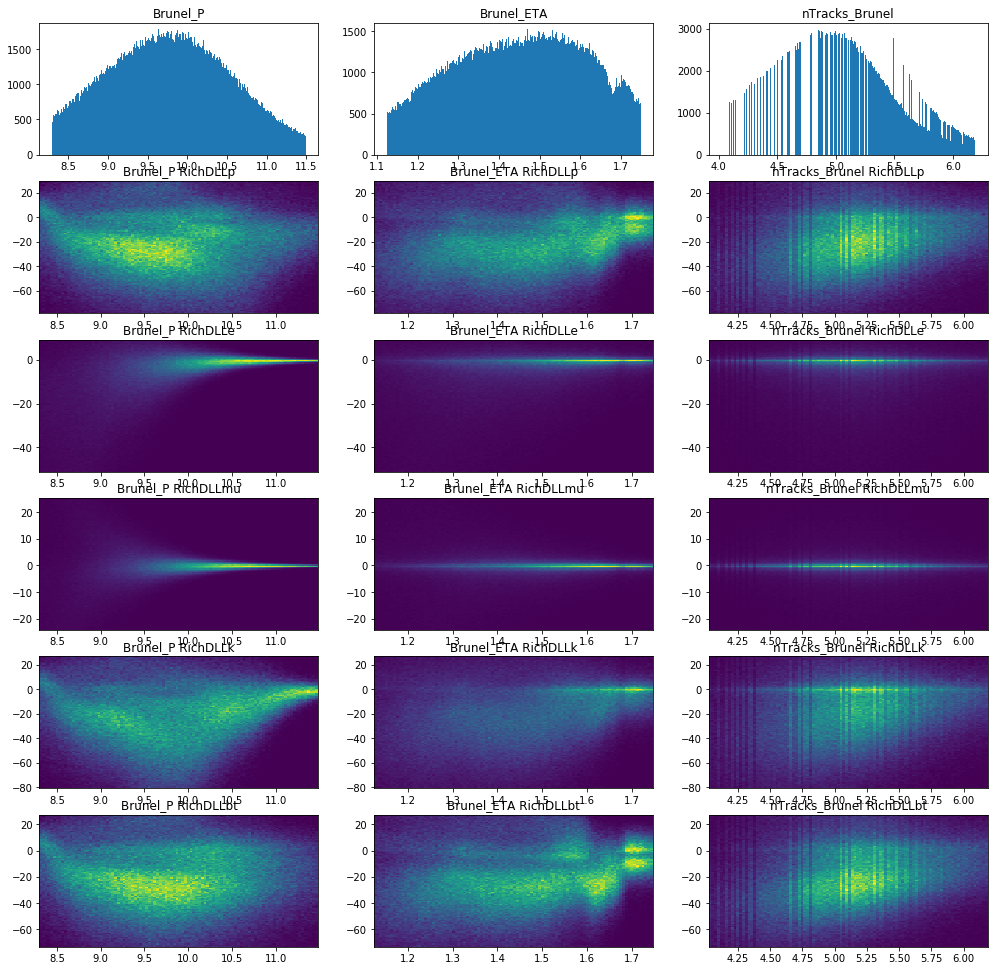

In [163]:
d1_ = d1.copy()
d1_[features] = np.log(d1_[features] + 1)
plot_joint_cond_dll_distributions(d1_, dlls, features)

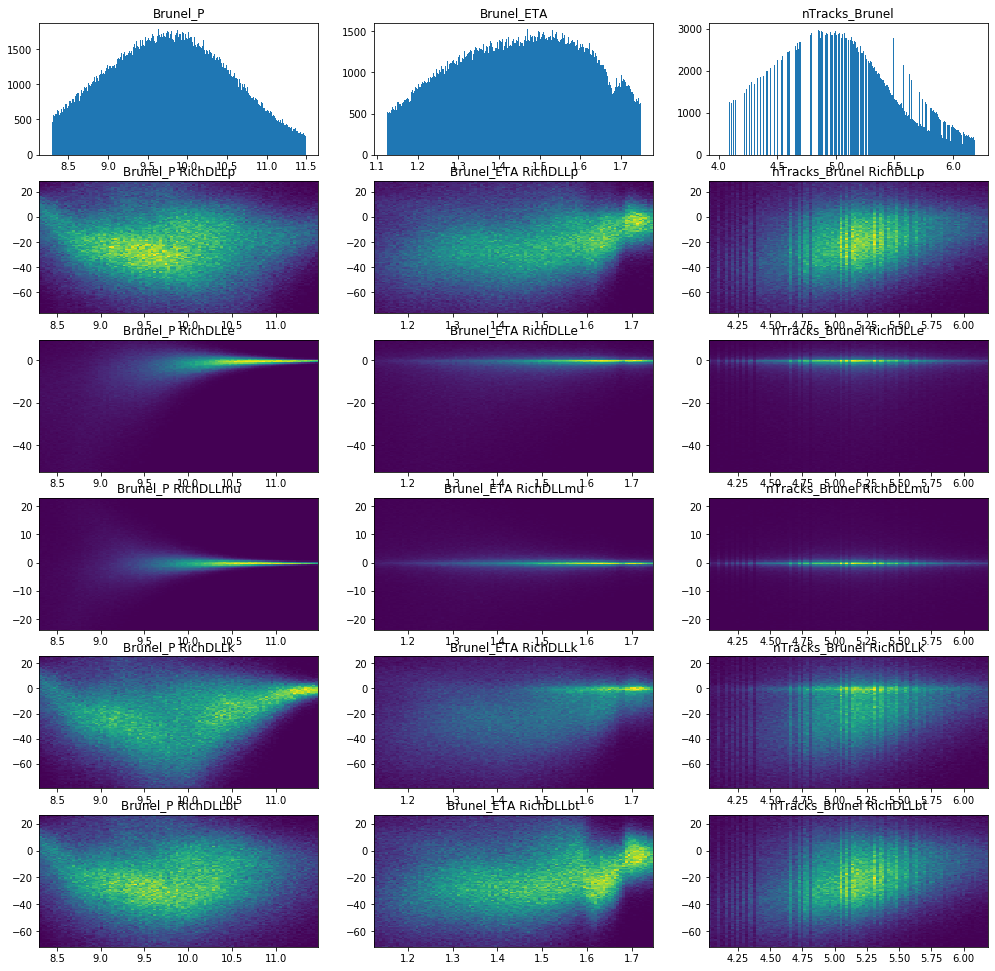

In [164]:
d2_ = d2.copy()
d2_[features] = np.log(d2_[features] + 1)
plot_joint_cond_dll_distributions(d2_, dlls, features)

In [165]:
n = d1.shape[0]
classification_ds = pd.concat([d1, d2]).sample(frac=1)
classification_ds.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsGenerated
128761,-23.524000,1.186780,0.197556,-8.229240,-20.229500,69254.296875,3.50116,225.0,-0.385250,False
237509,-6.612312,22.074070,26.854664,-6.633147,-6.659873,6113.180176,2.81367,242.0,1.187970,True
410085,-25.641603,-0.250281,-0.135976,-4.011878,-32.054405,69207.000000,3.53048,83.0,0.820805,True
55636,11.038406,1.932146,1.694070,-1.656486,16.174034,22265.199219,3.53321,211.0,0.923306,True
319463,10.432030,-1.835687,-2.830989,11.344763,10.388765,9605.669922,3.86399,401.0,-0.368104,True
332473,-50.794102,4.335310,2.243090,-52.703201,-43.477798,30708.000000,2.89320,328.0,0.612249,False
148865,-17.671633,0.266907,0.298739,-0.044479,-5.990466,72590.703125,4.49943,141.0,-0.385743,True
78527,-30.885504,-44.213779,-19.179585,-30.924919,-31.015724,7844.750000,3.58387,114.0,-0.346763,True
130447,-39.591782,0.156513,4.341279,-47.366680,-39.639175,11336.200195,2.19656,91.0,1.073390,True
398088,-76.973701,-10.735700,3.459170,-83.602600,-76.973701,10672.799805,2.12480,75.0,1.143400,False


In [166]:
n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]
cls_train.shape, cls_val.shape

((833368, 10), (357158, 10))

In [167]:
from rich_utils.my_roc_auc import my_roc_auc

In [168]:
import xgboost as xgb

In [169]:
params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=24
)
xgb_model = xgb.XGBClassifier(**params)

In [170]:
xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsGenerated'].values.astype('int32'),
#     sample_weight=cls_train[weight_filed]
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [171]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_true = cls_val['IsGenerated'].values
cls_weights = cls_val[weight_filed].values

In [172]:
np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred)

0.5467132193594991

In [173]:
from sklearn.metrics import roc_auc_score

In [174]:
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
roc_auc_score(is_gen_true, is_gen_pred_probas)

0.5724652110413765

In [175]:
my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights)

0.6013243225155779

In [260]:
# samples = []
# model.eval()
# with torch.no_grad():
#     for i in range(0, len(X_train_tensor), batch_size):
#         batch = X_train_tensor[i: i + batch_size]

#         z = prior.sample_n(len(batch))
#         samples_, _ = model.backward(z, batch)
#         samples_ = samples_.detach().cpu().numpy()
#         samples_ = preprocessor.y_scaler.inverse_transform(samples_)
#         samples.append(samples_)
# samples = np.vstack(samples)

In [261]:
def sample_from_model(model, condition, preprocessor):
    samples = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(condition), batch_size):
            batch = condition[i: i + batch_size]

            z = model.prior.sample_n(len(batch))
            samples_, _ = model.backward(z, batch)
            samples_ = samples_.detach().cpu().numpy()
            samples_ = preprocessor.y_scaler.inverse_transform(samples_)
            samples.append(samples_)
    samples = np.vstack(samples)
    
    return samples

In [304]:
samples = sample_from_model(model, X_train_tensor, preprocessor)
d1 = pd.DataFrame(np.hstack([Y_train_, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

n = d1.shape[0]
classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
257903,-21.640591,-0.375333,-0.253972,-2.837362,-25.663681,1.356990,1.134843,-0.645953,1.249270,False
203455,-24.887199,-6.975580,-0.463713,-40.324100,-27.470100,0.051516,0.046838,0.718146,-0.134217,True
559073,-0.689631,-9.298850,26.914400,-0.689631,-0.689631,-1.452831,-0.885018,-0.070357,-0.367298,True
561552,27.169500,1.964850,-2.373130,39.256302,27.169500,-0.452962,-1.110443,1.025417,-0.316683,True
883226,-55.082767,-38.844597,-8.228413,-55.434875,-55.142101,-0.918203,-1.340037,-0.691898,-0.355924,False
15398,-105.066002,-2.219690,-0.298213,-118.781998,-105.066002,-0.105639,-1.649349,-0.459595,-0.386451,True
293168,37.162201,-1.330620,-0.773655,12.274400,-4.176800,2.078562,0.408624,-0.837358,-0.383380,True
1086479,-11.432940,-3.094648,-0.164493,-17.155071,-11.489100,-0.216819,-0.558024,0.725124,1.042760,False
972465,-24.844021,0.731787,1.157330,-24.788006,-24.838131,0.074482,-0.522411,1.007700,-0.376382,False
614438,-0.860971,-2.359655,-0.025727,-7.489806,-0.921923,-0.086954,0.610422,1.752357,0.921944,False


In [305]:
clf = CatBoostClassifier(
    1000, eval_metric='AUC',
    metric_period=100,
    use_best_model=False
).fit(
    cls_train[dlls + features].values,
    cls_train['IsReal'].values.astype('int32'),
    eval_set=(
        cls_val[dlls + features].values,
        cls_val['IsReal'].values.astype('int32'),
    )
)

Learning rate set to 0.261371
0:	test: 0.5200445	best: 0.5200445 (0)	total: 207ms	remaining: 3m 27s
100:	test: 0.5737924	best: 0.5737924 (100)	total: 14s	remaining: 2m 4s
200:	test: 0.5881494	best: 0.5881494 (200)	total: 28.1s	remaining: 1m 51s
300:	test: 0.5955557	best: 0.5955557 (300)	total: 42.3s	remaining: 1m 38s
400:	test: 0.6012255	best: 0.6012255 (400)	total: 56.7s	remaining: 1m 24s
500:	test: 0.6052088	best: 0.6052088 (500)	total: 1m 10s	remaining: 1m 10s
600:	test: 0.6087621	best: 0.6087621 (600)	total: 1m 25s	remaining: 56.5s
700:	test: 0.6111879	best: 0.6111879 (700)	total: 1m 39s	remaining: 42.5s
800:	test: 0.6137890	best: 0.6137890 (800)	total: 1m 54s	remaining: 28.4s
900:	test: 0.6161470	best: 0.6161470 (900)	total: 2m 8s	remaining: 14.1s
999:	test: 0.6182127	best: 0.6182127 (999)	total: 2m 22s	remaining: 0us

bestTest = 0.6182127339
bestIteration = 999



In [306]:
preds = clf.predict(cls_train[dlls + features], prediction_type='RawFormulaVal')

In [307]:
np.quantile(preds[~cls_train['IsReal'].values], 0.99), np.log(2)

(0.7126644778711335, 0.6931471805599453)

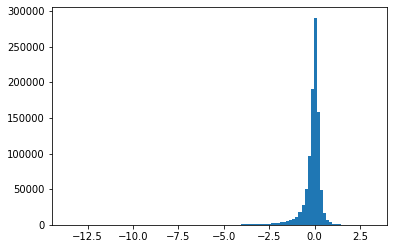

In [308]:
plt.hist(preds[~cls_train['IsReal'].values], bins=100);

In [309]:
clf_wrapper = lambda x: np.clip(clf.predict(x, prediction_type='RawFormulaVal'), -100, np.log(2))

In [310]:
clf.predict(cls_train[dlls + features].values[:10], prediction_type='RawFormulaVal')

array([-0.97029759,  0.02871178,  0.3992745 ,  0.27259571,  0.05269994,
        0.0191991 ,  1.58142671, -0.11698991,  0.34325711,  0.2231238 ])

In [311]:
clf_wrapper(cls_train[dlls + features].values[:10])

array([-0.97029759,  0.02871178,  0.3992745 ,  0.27259571,  0.05269994,
        0.0191991 ,  0.69314718, -0.11698991,  0.34325711,  0.2231238 ])

In [327]:
%%time
# dist = calib_model
# maj_dist = model
# c = 2
# condition = X_train_tensor

def rejection_sampling(dist, maj_dist, c, condition):
    need_sample = np.ones(len(condition), dtype=np.bool)
    samples = np.empty((len(condition), maj_dist.dim, ))
    np_cond = condition.detach().cpu().numpy()
    while True:
        idxs = np.where(need_sample)[0]
        if len(idxs) == 0:
            break
        samples_ = sample_from_model(maj_dist, condition[idxs], preprocessor)
        accept_log_prob = dist.clf(np.hstack([samples_, np_cond[idxs]])) - np.log(c)
        is_accept = (accept_log_prob > np.log(np.random.uniform(0, 1, len(idxs))))
        need_sample[idxs[is_accept]] = False
        samples[idxs[is_accept]] = samples_[is_accept]
    return samples

samples = rejection_sampling(calib_model, model, 2, X_train_tensor)
samples.shape

CPU times: user 37.1 s, sys: 3.24 s, total: 40.4 s
Wall time: 10 s


(1388946, 5)

In [328]:
# samples = sample_from_model(model, X_train_tensor, preprocessor)
d1 = pd.DataFrame(np.hstack([Y_train_, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

n = d1.shape[0]
classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
220518,5.465827,4.364344,0.704477,5.278239,5.366619,-0.985471,0.055490,0.004465,0.277685,False
487259,-21.374701,-41.507301,-18.046499,-21.374701,-21.374701,-1.644657,-1.253437,-1.129777,-0.378233,True
617573,-38.901318,-51.920258,-17.464081,-38.892075,-38.916576,-0.978550,-0.033137,-1.149763,1.206250,False
1165822,13.682888,-0.931385,0.230264,-1.176225,3.337702,0.729166,0.190154,2.435438,1.247460,False
1376133,12.782654,-3.836377,2.711978,12.804594,12.734413,-0.963595,-0.171662,0.833173,-0.354404,False
161802,-40.218651,-0.770000,-0.043940,-33.383400,-22.805260,0.805508,0.728561,-0.959390,1.238500,False
778658,-24.842438,-59.704170,-46.575089,-24.801271,-24.874079,-1.851904,-1.487961,-0.923656,-0.383213,False
293176,-10.871317,-7.024191,-2.075376,-19.596228,-10.903293,0.048853,0.613594,1.188113,-0.396233,False
1343370,-41.168140,-57.761005,-31.619104,-41.266876,-41.444092,-1.387254,-0.565935,0.928805,1.041630,False
1141915,-58.384544,-5.171176,0.485868,-77.843384,-58.386501,-0.143044,-0.727358,0.661313,-0.397028,False


In [330]:
params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=24
)
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsReal'].values.astype('int32'),
#     sample_weight=cls_train[weight_filed]
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [331]:
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
roc_auc_score(cls_val['IsReal'].values, is_gen_pred_probas)

0.5293593707632439

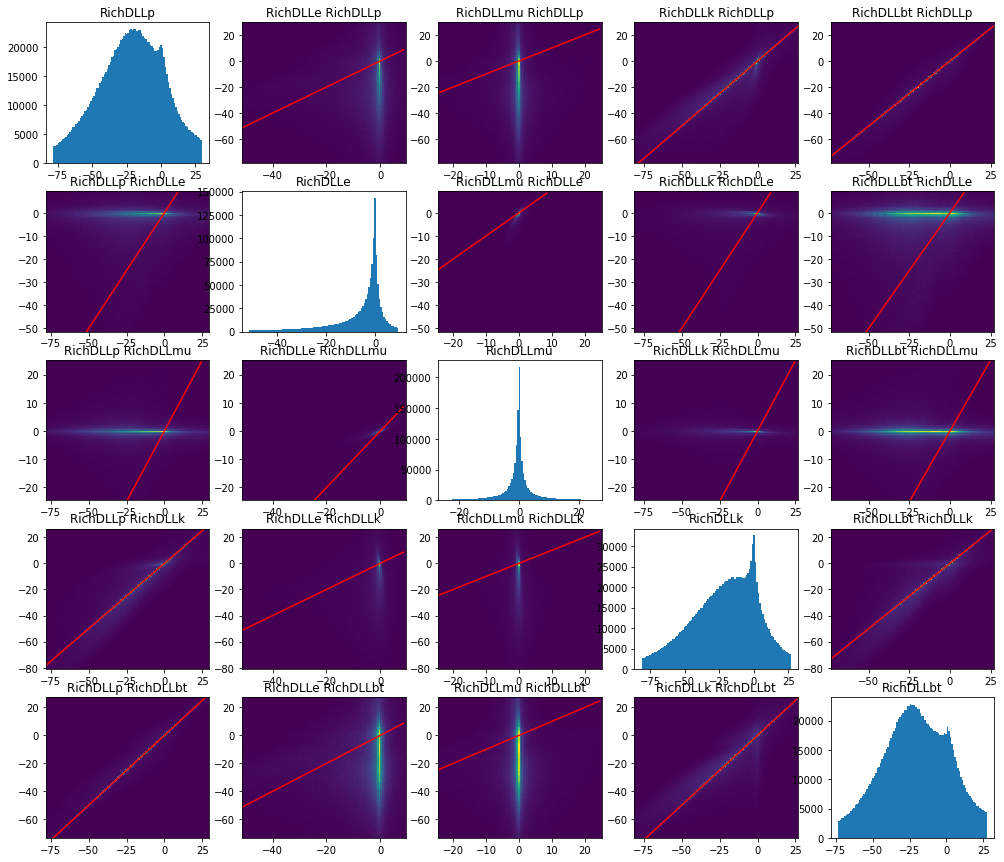

In [332]:
plot_joint_dll_distributions(d1, dlls)

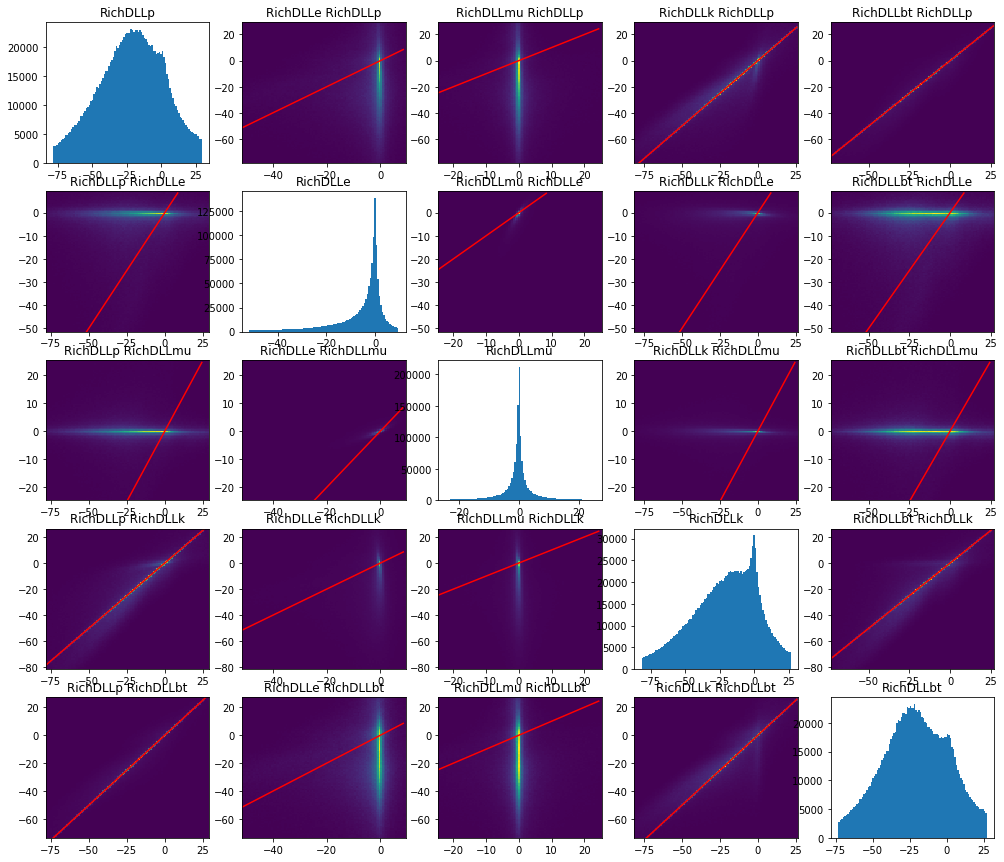

In [333]:
plot_joint_dll_distributions(d2, dlls)

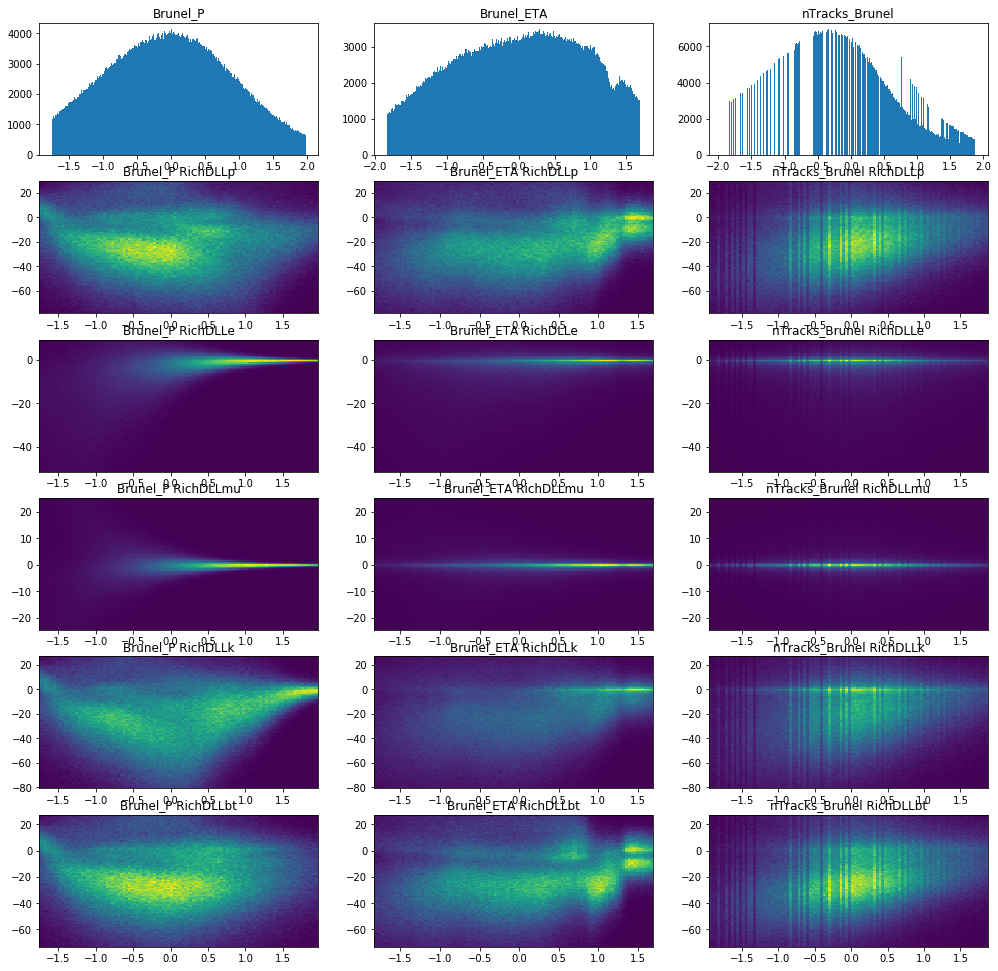

In [336]:
plot_joint_cond_dll_distributions(d1, dlls, features)

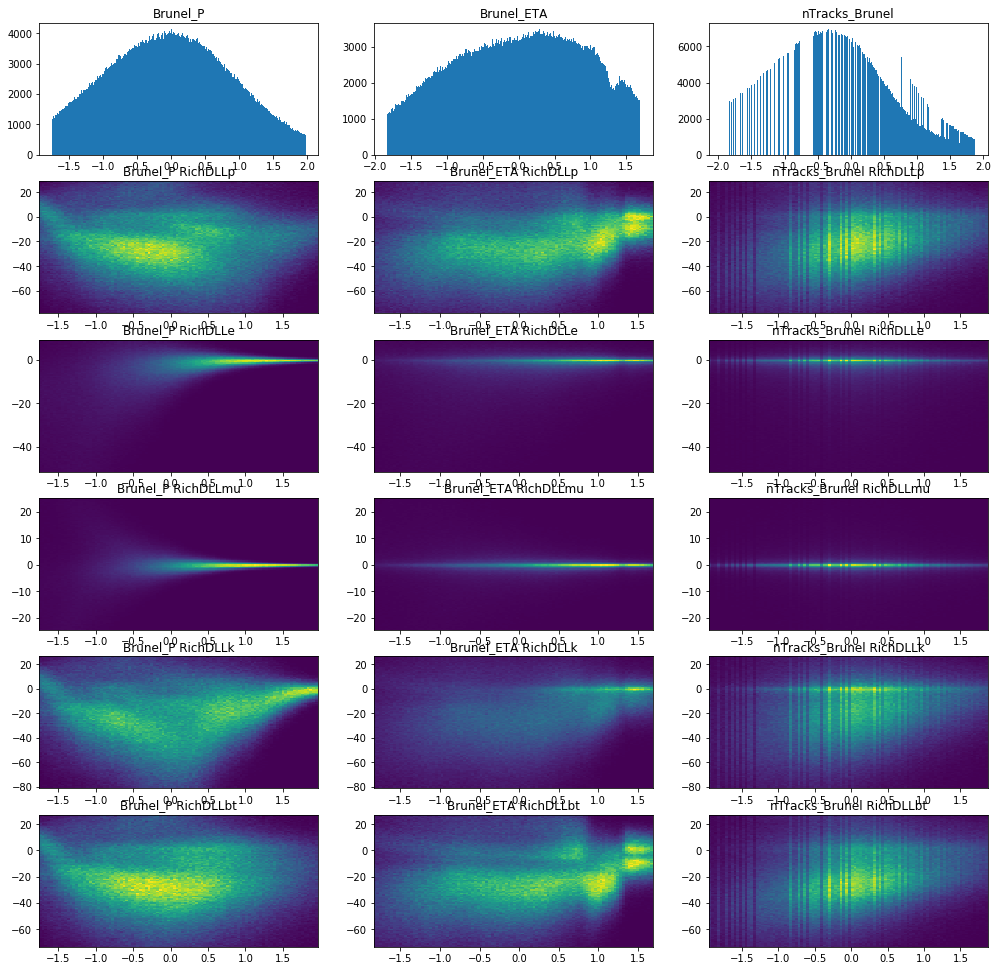

In [337]:
plot_joint_cond_dll_distributions(d2, dlls, features)

In [208]:
class ConditionalCalibratedModel:
    def __init__(self, clf, model: nn.Module, c: int):
        super().__init__()
        self.clf = clf
        self.model = model
        self.c = c

    def log_prob(self, x: np.ndarray, condition: np.ndarray) -> np.ndarray:
        discr = self.clf(np.hstack([x, condition]))

        with torch.no_grad():
            self.model.eval()
            x = torch.from_numpy(x).to(device)
            _, log_probs, log_det = self.model(x, condition)
            log_probs = (log_probs + log_det).detach().cpu().numpy()

        return log_probs + discr

    def sample_n(self, condition: np.ndarray) -> np.ndarray:
        return rejection_sampling(self, self.model, self.c, condition)

    def __repr__(self):
        return f'CalibratedModel(clf={self.clf}, model={self.model}, c={self.c}, logit={self.logit})'

In [225]:
def rejection_sampling(dist, maj_dist, c, condition):
    need_sample = np.ones(len(condition), dtype=np.bool)
    samples = np.empty((len(condition), maj_dist.dim, ))
    np_cond = condition.detach().cpu().numpy()
    while True:
        idxs = np.where(need_sample)[0]
        samples_ = sample_from_model(maj_dist, condition[idxs], preprocessor)
        accept_log_prob = dist.clf(np.hstack([samples_, np_cond[idxs]])) - np.log(c)

        is_accept = accept_log_prob > np.log(np.random.uniform(0, 1, len(idxs)))
        need_sample[idxs[is_accept]] = False
        samples[idxs[is_accept]] = samples_[is_accept]
    return samples

In [226]:
calib_model = ConditionalCalibratedModel(clf_wrapper, model, 2)

In [ ]:
clf_wrapper()

In [246]:
clf_wrapper(np.hstack([samples_, np_cond]))

array([0.69314718, 0.69314718, 0.58923152, 0.69314718, 0.69314718])

In [227]:
calib_model.sample_n(X_test_tensor)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


ValueError: need at least one array to concatenate